In [1]:
import pandas as pd
import zipfile
import warnings

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from category_encoders import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.utils.validation import check_is_fitted

warnings.simplefilter(action="ignore", category=FutureWarning)

In [2]:
zf = zipfile.ZipFile('C:/Users/SIR TONY/Desktop/Coding Materials/data/NepalEarthquakeDamage2015.zip')

In [3]:
def wrangle(path):
   
    # Read CSV file into DataFrame
    df = pd.read_csv(path)
    
    # drop NaN values
    df.dropna(inplace=True)
    
    # identify leaky columns
    drop_cols = [col for col in df.columns if 'post_eq' in col]
    
    # create binary target 
    df["damage_grade"] = df["damage_grade"].str[-1].astype(int)
    df["severe_damage"] = (df["damage_grade"] > 3).astype(int)
    
    # drop old target
    drop_cols.append("damage_grade")
    
    # Drop multicollinearlity feature
    drop_cols.append("count_floors_pre_eq")
    
    # Drop a high-cardinality feature
    drop_cols.append("building_id")
    
    # drop columns
    df.drop(columns=drop_cols, inplace=True)
    
    return df

In [4]:
df = wrangle(zf.open("NepalEarhquakeDamage2015.csv"))

In [5]:
df.head()

,district_id,age_building,plinth_area_sq_ft,height_ft_pre_eq,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,severe_damage
0,12,9,288,9,Flat,Other,Bamboo/Timber-Light roof,Mud,Not applicable,Not attached,Rectangular,0
1,12,15,364,9,Flat,Other,Bamboo/Timber-Light roof,Mud,Not applicable,Not attached,Rectangular,1
2,12,20,384,9,Flat,Other,Bamboo/Timber-Light roof,Mud,Not applicable,Not attached,Rectangular,0
3,12,20,312,9,Flat,Other,Bamboo/Timber-Light roof,Mud,Not applicable,Not attached,Rectangular,0
4,12,30,308,9,Flat,Other,Bamboo/Timber-Light roof,Mud,Not applicable,Not attached,Rectangular,0


In [8]:
df.shape

(762094, 12)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 762094 entries, 0 to 762105
Data columns (total 12 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   district_id             762094 non-null  int64 
 1   age_building            762094 non-null  int64 
 2   plinth_area_sq_ft       762094 non-null  int64 
 3   height_ft_pre_eq        762094 non-null  int64 
 4   land_surface_condition  762094 non-null  object
 5   foundation_type         762094 non-null  object
 6   roof_type               762094 non-null  object
 7   ground_floor_type       762094 non-null  object
 8   other_floor_type        762094 non-null  object
 9   position                762094 non-null  object
 10  plan_configuration      762094 non-null  object
 11  severe_damage           762094 non-null  int32 
dtypes: int32(1), int64(4), object(7)
memory usage: 72.7+ MB


In [10]:
df.columns

Index(['district_id', 'age_building', 'plinth_area_sq_ft', 'height_ft_pre_eq',
       'land_surface_condition', 'foundation_type', 'roof_type',
       'ground_floor_type', 'other_floor_type', 'position',
       'plan_configuration', 'severe_damage'],
      dtype='object')

In [11]:
# Check your work
assert df.shape[0] == 762094, f"`df` should have 70,836 rows, not {df.shape[0]}."

In [12]:
# Check your work
assert (
    df.filter(regex="post_eq").shape[1] == 0
), "`df` still has leaky features. Try again!"

In [13]:
# Check your work
assert (
    "damage_grade" not in df.columns
), "Your DataFrame should not include the `'damage_grade'` column."
assert (
    "severe_damage" in df.columns
), "Your DataFrame is missing the `'severe_damage'` column."
assert (
    df["severe_damage"].value_counts().shape[0] == 2
), f"The `'damage_grade'` column should have only two unique values, not {df['severe_damage'].value_counts().shape[0]}"

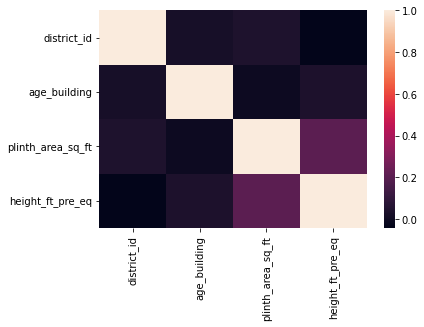

In [14]:
df["severe_damage"].corr(df["height_ft_pre_eq"])
# Create correlation matrix
correlation = df.select_dtypes("number").drop(columns="severe_damage").corr()
# Plot heatmap of `correlation`
sns.heatmap(correlation);

In [15]:
# Check your work
assert (
    "count_floors_pre_eq" not in df.columns
), "Did you drop the `'count_floors_pre_eq'` column?"

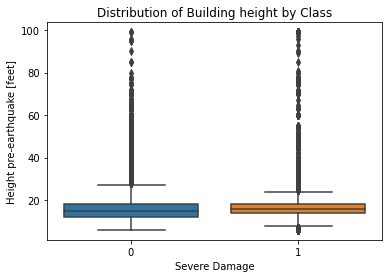

In [16]:
# Create boxplot
sns.boxplot(x="severe_damage", y="height_ft_pre_eq", data=df)
# Label axes
plt.xlabel("Severe Damage")
plt.ylabel("Height pre-earthquake [feet]")
plt.title("Distribution of Building height by Class");

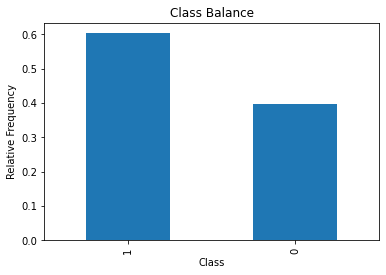

In [17]:
# Plot value counts of `"severe_damage"`
df["severe_damage"].value_counts(normalize=True).plot(
    kind="bar", xlabel="Class", ylabel="Relative Frequency", title="Class Balance"
);

In [18]:
majority_class_prop, minority_class_prop = df["severe_damage"].value_counts(normalize=True)
print(majority_class_prop, minority_class_prop)

0.6030883329353072 0.39691166706469283


In [19]:
# Check your work
assert (
    majority_class_prop < 1
), "`majority_class_prop` should be a floating point number between 0 and 1."
assert (
    minority_class_prop < 1
), "`minority_class_prop` should be a floating point number between 0 and 1."

In [20]:
# Create pivot table
foundation_pivot = pd.pivot_table(
    df, index='foundation_type', values='severe_damage', aggfunc=np.mean
).sort_values(by="severe_damage")
foundation_pivot

,severe_damage
foundation_type,
RC,0.038263
Bamboo/Timber,0.237855
Cement-Stone/Brick,0.296904
Other,0.510545
Mud mortar-Stone/Brick,0.685115


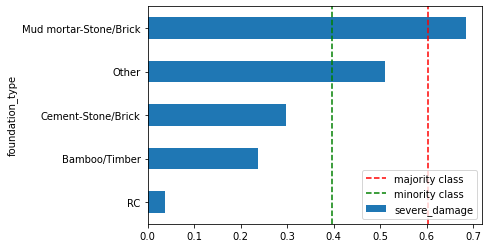

In [21]:
# Plot bar chart of `foundation_pivot`
foundation_pivot.plot(kind="barh", legend=None)
plt.axvline(
    majority_class_prop, linestyle="--", color="red", label="majority class"
)
plt.axvline(
    minority_class_prop, linestyle="--", color="green", label="minority class"
)
plt.legend(loc="lower right");

In [22]:
# Check for high- and low-cardinality categorical features
df.select_dtypes("object").nunique()
df.head()

,district_id,age_building,plinth_area_sq_ft,height_ft_pre_eq,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,severe_damage
0,12,9,288,9,Flat,Other,Bamboo/Timber-Light roof,Mud,Not applicable,Not attached,Rectangular,0
1,12,15,364,9,Flat,Other,Bamboo/Timber-Light roof,Mud,Not applicable,Not attached,Rectangular,1
2,12,20,384,9,Flat,Other,Bamboo/Timber-Light roof,Mud,Not applicable,Not attached,Rectangular,0
3,12,20,312,9,Flat,Other,Bamboo/Timber-Light roof,Mud,Not applicable,Not attached,Rectangular,0
4,12,30,308,9,Flat,Other,Bamboo/Timber-Light roof,Mud,Not applicable,Not attached,Rectangular,0


In [23]:
target = "severe_damage"
X = df.drop(columns=target)
y = df[target]

In [24]:
# Perform a randomized train-test split using scikit-learn.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (609675, 11)
y_train shape: (609675,)
X_test shape: (152419, 11)
y_test shape: (152419,)


In [25]:
y_train.value_counts(normalize=True).max()
acc_baseline = y_train.value_counts(normalize=True).max()
print("Baseline Accuracy:", round(acc_baseline, 2))

Baseline Accuracy: 0.6


In [26]:
# Build model
model = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    LogisticRegression(max_iter=1000)
)
# Fit model to training data
model.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['land_surface_condition',
                                     'foundation_type', 'roof_type',
                                     'ground_floor_type', 'other_floor_type',
                                     'position', 'plan_configuration'],
                               use_cat_names=True)),
                ('logisticregression', LogisticRegression(max_iter=1000))])

In [27]:
# Check your work
assert isinstance(
    model, Pipeline
), f"`model` should be a Pipeline, not type {type(model)}."
assert isinstance(
    model[0], OneHotEncoder
), f"The first step in your Pipeline should be a OneHotEncoder, not type {type(model[0])}."
assert isinstance(
    model[-1], LogisticRegression
), f"The last step in your Pipeline should be LogisticRegression, not type {type(model[-1])}."

In [28]:
check_is_fitted(model)

In [29]:
acc_train = accuracy_score(y_train, model.predict(X_train))
acc_test = accuracy_score(y_test, model.predict(X_test))

print("Training Accuracy:", round(acc_train, 2))
print("Test Accuracy:", round(acc_test, 2))

Training Accuracy: 0.72
Test Accuracy: 0.72


In [30]:
model.predict(X_train)[:5]
y_train_pred_proba = model.predict_proba(X_train)
print(y_train_pred_proba[:5])

[[0.2703675  0.7296325 ]
 [0.28134459 0.71865541]
 [0.24131747 0.75868253]
 [0.36304331 0.63695669]
 [0.26042267 0.73957733]]


In [31]:
features = model.named_steps["onehotencoder"].get_feature_names()
importances = model.named_steps["logisticregression"].coef_[0]

In [32]:
odds_ratios = pd.Series(np.exp(importances), index=features).sort_values()
odds_ratios.head()

ground_floor_type_RC             0.274739
foundation_type_Bamboo/Timber    0.349310
roof_type_RCC/RB/RBC             0.397520
foundation_type_RC               0.517891
other_floor_type_RCC/RB/RBC      0.587077
dtype: float64

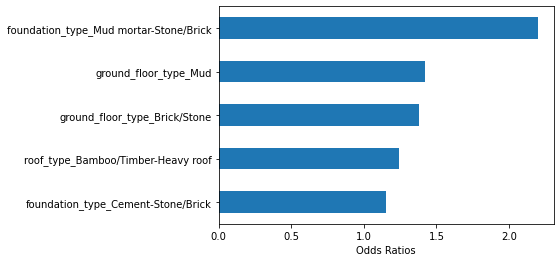

In [33]:
# Horizontal bar chart, five largest coefficients
odds_ratios.tail().plot(
    kind="barh"
)
plt.xlabel("Odds Ratios");

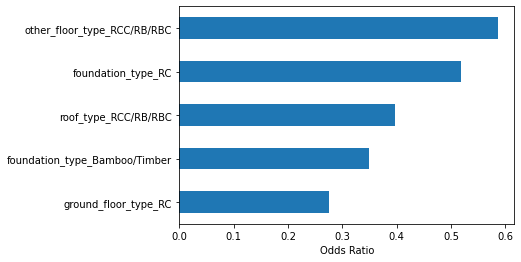

In [34]:
# Horizontal bar chart, five smallest coefficients
odds_ratios.head().plot(kind="barh")
plt.xlabel("Odds Ratio");